In [1]:
import pystache, plotly, json, random, sys, yaml, glob, os
import pandas as pd
import plotly.graph_objects as go

from google.cloud import bigquery
from google.oauth2 import service_account
from datetime import datetime


# Create Interactive Diffusion Graph for Retweets of the CDC that Trump also retweeted

1. Reads yaml configuration file from `/home/jupyter/data/www/covid19-static-pages/configs/cdc-trump.special`
2. Queries for retweets from Big Query including extra user information.
3. Processes and produces simplified JSON output of retweets.
3. Reads simplified JSON into Plotly and writes JSON configurations for Plotly Graphs and HTML files.

In [2]:
credentials = service_account.Credentials.from_service_account_file(
    '/home/jupyter/covid-19-data/.credentials/google-connector.json')
project_id = 'crypto-eon-164220'
client = bigquery.Client(credentials=credentials, project=project_id)

## 1. Get top retweets from Big Query

In [3]:
def get_top_N_retweeted_tweets(table, N=25): #Limits to 25 for safety
    sys.stderr.write("Querying for top {} retweets in {}...".format(N, table))
    
    query_job = client.query("""
SELECT
  id AS retweet_id,
  min(original_tweet_id) AS orig_id,
  min(tweet_text) AS orig_text,
  min(source) AS source,
  min(times_retweeted_) AS times_retweeted,
  min(original_author) AS orig_author,
  min(original_followers) as orig_followers_count,
  min(original_posted) AS orig_posted,
  min(user.screen_name) AS retweeter,
  min(user.id_str) AS retweeter_id,
  min(user.created_at) AS retweeter_join_date,
  min(user.followers_count) AS retweeter_followers_count,
  min(PARSE_TIMESTAMP('%a %b %d %T %z %Y', created_at)) AS retweet_timestamp
FROM
  `crypto-eon-164220.tweets.{TABLE}` tweets,
  (
  SELECT
    MIN(retweeted_status.id) AS original_tweet_id,
    MIN(retweeted_status.text) AS tweet_text,
    MIN(retweeted_status.user.screen_name) AS original_author,
    MIN(retweeted_status.user.followers_count) AS original_followers,
    MIN(PARSE_TIMESTAMP('%a %b %d %T %z %Y', retweeted_status.created_at)) AS original_posted,
    COUNT(DISTINCT(id)) AS times_retweeted_
  FROM
    `crypto-eon-164220.tweets.{TABLE}`
  WHERE
    retweeted_status IS NOT NULL
    AND retweeted_status.id >= (SELECT MIN(id) FROM `crypto-eon-164220.tweets.{TABLE}`)
  GROUP BY
    retweeted_status.id
  ORDER BY times_retweeted_ DESC
  LIMIT {N}
  ) topRetweets
WHERE
  topRetweets.original_tweet_id = tweets.retweeted_status.id
GROUP by id
order by orig_id
""".format(TABLE=table,
           N=N) )
    
    sys.stderr.write("done; creating dataframe\n")
    return query_job.result().to_dataframe()


In [4]:
def create_dataframe_for_plotly(df, fileName):

    retweet_counts_by_id = list(df.orig_id.value_counts(ascending=False).keys())

    count = 0;
    to_return = pd.DataFrame()

    for original_id, retweets in df.groupby('orig_id'):
        count += 1;
        topN = retweet_counts_by_id.index(original_id) + 1 # The Top N tweet...
        print("Processing Tweet# {} - TopN [{}] - ID: {})".format(count, topN, original_id))

        sorted_retweets = retweets.sort_values(by='retweet_id').reindex()

        original_tweet = pd.DataFrame([{
            'id': sorted_retweets.iloc[0].orig_id,
            'created_at': sorted_retweets.iloc[0].orig_posted,
            'username': sorted_retweets.iloc[0].orig_author,
            'followers_count': sorted_retweets.iloc[0].orig_followers_count
        }])

        text = sorted_retweets.iloc[0].orig_text

        interested_rows = sorted_retweets[['retweet_id','retweet_timestamp','retweeter','retweeter_followers_count','source','retweeter_id','retweeter_join_date']]
        interested_rows.columns = ['id','created_at','username','followers_count','source','user_id','user_join_date']

        #Add the first row for the original tweet
        x = pd.concat([original_tweet, interested_rows]).reset_index(drop = True) 

        x['followers_count_cumsum'] = x.followers_count.cumsum()
        x['text'] = text
        x['top_N'] = topN
        
        x.created_at = x.created_at.apply(lambda x: x.isoformat())
        
        usernames = set(x.username)
        
        #Check if Trump or a Trump retweeting bot is there:
        if 'idontdonald' in usernames or 'realDonaldTrump' in usernames: 
            to_return = pd.concat([x, to_return])

    current_datestamp = datetime.today().strftime('%Y-%m-%d')
    with open(fileName +"_"+current_datestamp+'.json','w') as f:
        json.dump(to_return.sort_values(by='top_N').to_dict('records'), f)

In [5]:
def get_data(config):
    
    df = get_top_N_retweeted_tweets(config['table'], N= (config.get("topN") or 10) )
    
    create_dataframe_for_plotly(df, config['data'])


## 2. Create Plots

In [6]:
COLORS = plotly.colors.qualitative.Alphabet

In [7]:
def view_colors():
    sns.palplot(COLORS)

def normalize(values, desired_bounds):
    actual_bounds = (min(values), max(values))
    result = [desired_bounds[0] + (x - actual_bounds[0]) *
            (desired_bounds[1] - desired_bounds[0]) / \
            (actual_bounds[1] - actual_bounds[0]) for x in values]
    return [round(x,2) for x in result]

In [8]:
# Read the latest diffusion data...
def read_dataframe_from_file(CONFIG):

    #Get the latest file
    latest_file = sorted(glob.glob(CONFIG['data']+"*.json"))[-1]
    
    sys.stderr.write("Loading "+latest_file+"...")
    to_plot = json.load(open(latest_file,'r')) #Could put error handling here if necessary

    df = pd.DataFrame(to_plot)
    df['timestamp'] = df.created_at.apply(lambda t: pd.Timestamp(t))
    
#     print(df.timestamp.head())
    
    #Convert all timestamps to EST (Trump's timezone)
    df.timestamp = df.timestamp.apply(lambda t: t.tz_convert('EST'))
    
#     print(df.timestamp.head())
    
    sys.stderr.write(("Read {:,} retweets\n".format(len(to_plot))))

    return df

In [9]:
def makeDateStringForName(d):
    
#     return d.isoformat()
    
    return "{} {} {:02d}:{:02d}:{:02d} (EST)".format( d.month_name()[0:3], d.day, d.hour,d.minute,d.second)

def calculate_self_retweets(input_df):

    sys.stderr.write("Discounting self-retweets: [")
    df = pd.DataFrame.copy(input_df, deep=True)
    
    tweet_data = {}

    for topN in df.top_N.unique():
        newCounter = 0
        subValue = 0
        
        trump_retweet_time = None
        this_tweet_data = None

        for idx, row in df[df.top_N == topN].sort_values(by='id').iterrows():
                        
            if newCounter==0:
                thisUser = row.username
                origFollowerCount = row.followers_count
                origTweetID = str(row.id)
                this_tweet_data = {
                    'text' : row.text,
                    'user' : thisUser,
                    'topN' : int(topN),
                    'color': COLORS[topN%len(COLORS)],
                    'id'   : origTweetID,
                    'self-rt' : [],
                    'time' : row.timestamp.isoformat()
                }
            
            else:
                if row.username == thisUser:
                    if row.followers_count > origFollowerCount:
                        subValue = origFollowerCount
                    else:
                        subValue = row.followers_count
                    this_tweet_data['self-rt'].append(
#                         "2020-04-19T01:53:07+00:00"
                        {'x':row.timestamp.isoformat(), 'subValue':subValue}
                    )                    
        
            #Add Trump timestamp to the tweet data for the ranking...
            if row.username == 'realDonaldTrump':
                trump_retweet_time = makeDateStringForName( row.timestamp )
                
                #Also reset "rank" value here
            
            if subValue > 0:
                df.loc[idx,'followers_count_cumsum'] = row.followers_count_cumsum - subValue
            newCounter += 1;
        
        if not trump_retweet_time:
            #Use 5 seconds prior to idontdonald
            row = df[df.top_N == topN].query('username=="idontdonald"')
            print(row.timestamp)
            x = row.timestamp - pd.Timedelta(seconds=5)
            trump_retweet_time = makeDateStringForName( x.iloc[0] ) 
            print(trump_retweet_time)
            
        this_tweet_data['rank'] = trump_retweet_time
            
        tweet_data[trump_retweet_time] = this_tweet_data
            
        sys.stderr.write("{},".format(topN))
        
    sys.stderr.write("] done\n".format(topN))
    
    return (df, tweet_data)

In [10]:
def custom_label(row):
    return "{}: {} followers".format(row.username, row.followers_count)
    

def buildPlotlyGraph(df, tweet_data):
    sys.stderr.write("Plotting...")
    
#     df['globalScaledMarker'] = df.followers_count.apply(lambda x: np.log2(x+1))
    df['globalScaledMarker'] = normalize(list(df.followers_count), (10,100))

    fig = go.Figure()

    for tweetTimeStamp in sorted(tweet_data.keys()):
        topNidx = tweet_data[tweetTimeStamp].get('topN')

        #Should be sorted safely?
        plot_df = df[df.top_N==topNidx].sort_values(by='id')

        if len(plot_df) > 0:

            tweetId   = str(plot_df.head(1).id.values[0])
            tweetText = plot_df.head(1).text.values[0]

            if pd.isna(tweetText):
                raise "No Tweet Text on First Entry"

            color = COLORS[topNidx%len(COLORS)]

            fig.add_trace(go.Scattergl(
                name = tweetTimeStamp, #rank
                x    = plot_df.timestamp, 
                y    = plot_df.followers_count_cumsum,
                mode = 'markers+lines',
                marker = dict(
                    size  = plot_df.globalScaledMarker, #normalize(list(plot_df.followers_count), (10,35)),
                    color = color,
                    opacity = 0.5,
                    line=dict(
                        color='white',
                        width=0.4
                    ),
                ),
                line=dict(
                    color=color,
                    width=0.75,
                ),
                hovertemplate ='%{x} - %{text}',
                text = list(plot_df.apply(lambda row: custom_label(row), axis=1)),
                meta={'u':plot_df.username,
                      'f':plot_df.followers_count },
                showlegend = True
            ))
            sys.stderr.write(".")

    fig.update_layout(
        autosize=False,
        width=1400,
        height=600,
        margin=dict(
            t=1,r=50,l=1,b=1
        ),
        legend=dict(
            x=1,
            y=1,
            traceorder="normal",
            font=dict(
                family="sans-serif",
                size=12,
                color="black"
            ),
    ),
        yaxis_title="Potential Audience Exposure",)

    sys.stderr.write("] Done\n")
    return fig

In [11]:
def buildSingleStaticPlotlyPage(CONFIG):
    sys.stderr.write("Writing HTML... ")

    main_template = open(STATIC_PAGES_ROOT + '/templates/plotly_js_template.html').read()

    with open(STATIC_PAGES_ROOT + "/" + CONFIG['output'],'w') as outFile:
        outFile.write(pystache.render(main_template, CONFIG))
    sys.stderr.write(" view at: http://epic.tweetsonamap.com/covid19-static-pages/"+CONFIG['output']+"\n")

<br><br><hr><br><br>

# Runtime


In [12]:
# GLOBAL VARIABLES?
STATIC_PAGES_ROOT = '/home/jupyter/data/www/covid19-static-pages'

In [13]:
def full_run(yaml_config, query=True, plot=True, write_html=True):
    print("Building page for: {}".format(yaml_config))
    config = yaml.load(open(yaml_config,'r'),
                       Loader=yaml.FullLoader)
    
    if query:
        get_data(config)
    
    if plot:
        config['df'] = read_dataframe_from_file(config)
    
        topN = config.get('topN') or 25
    
        config['no_self_retweets'], config['tweets'] = calculate_self_retweets(config['df'] )

        config['fig'] = buildPlotlyGraph(config['no_self_retweets'], config['tweets'])
    
        figJSON = json.loads(plotly.io.to_json(config['fig']))
        figJSON['tweets'] = config['tweets']
        
        with open(STATIC_PAGES_ROOT +"/docs/"+ config['JSON'],'w') as outFile: 
            json.dump(figJSON, outFile)
            
    if write_html:
        buildSingleStaticPlotlyPage(config)
    
    return config

In [14]:
# Do some testing?
# full_run('/home/jupyter/data/www/covid19-static-pages/configs/covid-maps.yaml')

x = full_run('/home/jupyter/data/www/covid19-static-pages/configs/cdc-trump.special', query=False, plot=True)


Building page for: /home/jupyter/data/www/covid19-static-pages/configs/cdc-trump.special


Loading /home/jupyter/data/diffusion/cdc_userstreams_with_trump_2020-06-17.json...Read 44,256 retweets
Discounting self-retweets: [

4315   2020-04-25 08:02:01-05:00
Name: timestamp, dtype: datetime64[ns, EST]
Apr 25 08:01:56 (EST)


1,2,3,4,5,6,7,8,10,11,12,13,14,15,] done
Plotting.................] Done
Writing HTML...  view at: http://epic.tweetsonamap.com/covid19-static-pages/docs/cdc-trump.html


## Build other datasets for comparisons

In [15]:
y = x['no_self_retweets'].sort_values(by=['top_N','id']).set_index('id')

In [16]:
y.head()

,created_at,username,followers_count,source,user_id,user_join_date,followers_count_cumsum,text,top_N,timestamp,globalScaledMarker
id,,,,,,,,,,,
1253742258853199872,2020-04-24T17:47:02+00:00,CDCgov,2615841,NaN,NaN,NaN,2615841,Household cleaners and disinfectants can cause...,1,2020-04-24 12:47:02-05:00,12.93
1253742282479673345,2020-04-24T17:47:08+00:00,monitor_PH,1057,"<a href=""https://twitter.com/pubhealth_watch"" ...",8.699671e+17,Wed May 31 17:21:27 +0000 2017,2616898,Household cleaners and disinfectants can cause...,1,2020-04-24 12:47:08-05:00,10.00
1253742322464022528,2020-04-24T17:47:17+00:00,WarnckeMelissa,17,"<a href=""http://twitter.com/download/iphone"" r...",1.144984e+18,Sat Jun 29 14:59:23 +0000 2019,2616915,Household cleaners and disinfectants can cause...,1,2020-04-24 12:47:17-05:00,10.00
1253742324145889281,2020-04-24T17:47:18+00:00,tedbrunson,291,"<a href=""http://twitter.com/download/iphone"" r...",2.210122e+07,Fri Feb 27 03:19:03 +0000 2009,2617206,Household cleaners and disinfectants can cause...,1,2020-04-24 12:47:18-05:00,10.00
1253742325215395841,2020-04-24T17:47:18+00:00,HBMS_Warriors,619,"<a href=""https://mobile.twitter.com"" rel=""nofo...",7.036128e+08,Wed Jul 18 19:05:22 +0000 2012,2617825,Household cleaners and disinfectants can cause...,1,2020-04-24 12:47:18-05:00,10.00


In [17]:
def int_or_none(val):
    try:
        return str(int(val))
    except:
        return None

def set_type(val):
    if pd.isna(val):
        return 'original tweet'
    else:
        return 'retweet'

lookup = dict( [(u['topN'], u['rank']) for u in x['tweets'].values()])

y['time_trump_retweeted'] = y.top_N.apply(lambda n: lookup[n])
y['type'] = y.user_id.apply(lambda u: set_type(u))
y.user_id = y.user_id.apply(lambda u: int_or_none(u))

y.head(2)

,created_at,username,followers_count,source,user_id,user_join_date,followers_count_cumsum,text,top_N,timestamp,globalScaledMarker,time_trump_retweeted,type
id,,,,,,,,,,,,,
1253742258853199872,2020-04-24T17:47:02+00:00,CDCgov,2615841,NaN,None,NaN,2615841,Household cleaners and disinfectants can cause...,1,2020-04-24 12:47:02-05:00,12.93,Apr 25 08:01:56 (EST),original tweet
1253742282479673345,2020-04-24T17:47:08+00:00,monitor_PH,1057,"<a href=""https://twitter.com/pubhealth_watch"" ...",869967070984851456,Wed May 31 17:21:27 +0000 2017,2616898,Household cleaners and disinfectants can cause...,1,2020-04-24 12:47:08-05:00,10.00,Apr 25 08:01:56 (EST),retweet


In [18]:
# Okay, ready to save some data...
complete_dataframe = pd.DataFrame(y[['created_at','username','followers_count','source','user_id','user_join_date','text','top_N','time_trump_retweeted','type']])
complete_dataframe.to_csv(open('cdc_retweeted_by_trump.csv','w'))
complete_dataframe.head(2)

,created_at,username,followers_count,source,user_id,user_join_date,text,top_N,time_trump_retweeted,type
id,,,,,,,,,,
1253742258853199872,2020-04-24T17:47:02+00:00,CDCgov,2615841,NaN,None,NaN,Household cleaners and disinfectants can cause...,1,Apr 25 08:01:56 (EST),original tweet
1253742282479673345,2020-04-24T17:47:08+00:00,monitor_PH,1057,"<a href=""https://twitter.com/pubhealth_watch"" ...",869967070984851456,Wed May 31 17:21:27 +0000 2017,Household cleaners and disinfectants can cause...,1,Apr 25 08:01:56 (EST),retweet


# Part II: Do the Stream Comparisons for SRC and % Similar 

In [31]:
from scipy.stats import spearmanr
from collections import Counter

In [32]:
#Get our keys
TRUMP_RETWEET_TIME_KEYS = sorted(set(complete_dataframe.time_trump_retweeted))
TIME_TRUMP_RETWEETED_BLEACH = pd.Timestamp("20200425T13:01:56Z") #This is 5 seconds before idontdonald

In [60]:
def get_retweets_after_trump(df, window=1, debug=False):
    """
        Returns a dictionary keyed by number (corresponding to the Trump KeyS) with dataframes as values of all the retweets of that tweet.
    """
    retweets_after_trump = {}

    for trumpLabel, retweets in df.groupby('time_trump_retweeted'):
        retweets = retweets.sort_values(by='created_at').reindex()
        retweets.created_at = retweets.created_at.apply(pd.Timestamp)
        
        index_of_trump_retweet = retweets[retweets.username == 'realDonaldTrump'].index

        #The tweet he deleted.  Obnoxious we have to do this.
        if trumpLabel==TRUMP_RETWEET_TIME_KEYS[2]:
            
            trumpTweetTime = TIME_TRUMP_RETWEETED_BLEACH
            
        elif index_of_trump_retweet.any() > 0:
            
            tweet = retweets.loc[min(index_of_trump_retweet)]
            trumpTweetTime = tweet.created_at
            
        print(trumpTweetTime)

        max_time = trumpTweetTime + pd.Timedelta(hours=window)
        
        if debug: 
            print("Tweet TrumpLabel: {}; ".format(trumpLabel), end="")
            print('@realDonaldTrump retweeted at '+ str( trumpTweetTime))


        in_window = retweets[(retweets.created_at > trumpTweetTime ) & (retweets.created_at <= max_time)]
        if debug: 
                print(str(len(in_window)) + " retweets in {} hour(s) after Trump".format(window)+"\n")
        
        retweets_after_trump[trumpLabel] = pd.DataFrame.copy(in_window)
        retweets_after_trump[trumpLabel]['timeSinceTrump'] = (retweets_after_trump[trumpLabel].created_at - trumpTweetTime)
            
    # How many tweets do users retweet?
    all_users = []
    all_sources = []
    for k in retweets_after_trump.keys():
        all_users   += list(retweets_after_trump[k].user_id)
        all_sources += list(retweets_after_trump[k].source)
    source_counts = Counter(all_sources)
    user_counts   = Counter(all_users)
            
    return [retweets_after_trump, source_counts, user_counts]


def calculate_similarity_of_tweeters_in_two_streams(streamA, streamB):
    """
        Returns the percentage of users that present in both streams
    """
    return len( set(streamA.user_id) & set(streamB.user_id) ) / min(len(streamA),len(streamB) )* 100

def rank_twitterers(streamA, streamB):
    """
    Returns dataframe for plotting
    """
    
    users = set(streamA.user_id) & set(streamB.user_id)
    
    p_similar = calculate_similarity_of_tweeters_in_two_streams(streamA,streamB);
    
#     print("The % similar is: {:.2f} with {} users in both streams".format(p_similar, len(users)))

    to_return = []

    for u in list(users):
        
        usernameA = streamA[streamA.user_id==u].username.values[0]
        usernameB = streamA[streamA.user_id==u].username.values[0]
        
        if usernameA == usernameB:
            username = usernameA
        else:
            username = usernameA + " | " + usernameB
            
        sourceA = streamA[streamA.user_id==u].source.values[0]
        sourceB = streamB[streamB.user_id==u].source.values[0]

        if sourceA == sourceB:
            source = sourceA
        else:
            source = sourceA + " | " + sourceB
        
        to_return.append(
            {'user_id':u, 
             'username': username,
             'source' : source,
             'rankInA':streamA[streamA.user_id==u].timeSinceTrump.values[0],
             'rankInB':streamB[streamB.user_id==u].timeSinceTrump.values[0]})

    thisDF = pd.DataFrame(to_return)
    sr = spearmanr(thisDF.rankInA, thisDF.rankInB)

    return thisDF, sr, p_similar

In [61]:
COLORS = plotly.colors.cyclical.Edge
def hoverTemplate(row):
    return row.username + ": " + row.source

def make_plot(df2, user_counts):
    
    df2['counts'] = df2.user_id.apply(lambda x: user_counts[x])
        
    fig = go.Figure()

    for count, rts in df2.groupby('counts'):
        if count < 17:
            fig.add_trace(go.Scattergl(
                name = 'Retweeted {} tweets'.format(count),
                x    = rts.rankInA.apply(lambda x: x.total_seconds()),
                y    = rts.rankInB.apply(lambda x: x.total_seconds()), 
                mode = 'markers',
                marker = dict(
                    size  = 8,
                    color = COLORS[count-1],
                    opacity = 1
                ),
                hovertemplate ='%{text}',
                text = rts.apply(lambda row: hoverTemplate(row), axis=1),
                showlegend = True
            ))

    fig.update_layout(
        autosize=False,
        width=800,
        height=600,
        margin=dict(
            t=50,r=50,l=1,b=1
        ),
        legend=dict(
            x=1,
            y=1,
            traceorder="normal",
            font=dict(
                family="sans-serif",
                size=12,
                color="black"
            )),
        title="Trump's Retweet at {} vs Retweet at {} \n ({},{})".format(A,B,
                                                                        TRUMP_RETWEET_TIME_KEYS.index(A),
                                                                        TRUMP_RETWEET_TIME_KEYS.index(B)),
        xaxis_title="Seconds since Trump Retweeted at #{}".format(A),
        yaxis_title="Seconds since Trump Retweeted at #{}".format(B))
    return fig

In [63]:
window=1

retweets_after_trump, source_counts, user_counts = get_retweets_after_trump(complete_dataframe, 
                                                                            window=window, debug=False)

#Which should we compare?
A = TRUMP_RETWEET_TIME_KEYS[2]
B = TRUMP_RETWEET_TIME_KEYS[3]

df2, sr, p = rank_twitterers(retweets_after_trump[A], retweets_after_trump[B])
print("The % similar is: {:.2f} with {} users in both streams".format(p, len(df2)))
print(sr)


f = make_plot(df2, user_counts)
f.show()

with open('/data/www/tmp.html','w') as outFile:
    outFile.write( plotly.io.to_html(f,include_plotlyjs='cdn') )

2020-04-25 12:12:10+00:00
2020-04-25 12:12:52+00:00
2020-04-25 13:01:56+00:00
2020-04-25 13:02:37+00:00
2020-04-25 13:02:51+00:00
2020-04-25 13:04:07+00:00
2020-04-25 13:05:16+00:00
2020-04-25 13:05:26+00:00
2020-04-25 13:05:51+00:00
2020-04-25 13:07:15+00:00
2020-04-25 13:08:14+00:00
2020-05-01 23:28:32+00:00
2020-05-25 02:29:01+00:00
2020-05-25 02:29:05+00:00
The % similar is: 73.95 with 491 users in both streams
SpearmanrResult(correlation=0.9616196930282267, pvalue=8.566916827808671e-277)


In [65]:
window=1

retweets_after_trump, source_counts, user_counts = get_retweets_after_trump(complete_dataframe, window=window)

for A in retweets_after_trump.keys():
    for B in retweets_after_trump.keys():
        if B > A:
            df2, sr, p = rank_twitterers(retweets_after_trump[A], retweets_after_trump[B])
            
            f = make_plot(df2, user_counts)
            with open('/data/www/covid19-static-pages/docs/retweet_correlations/{}_{}_{}H.html'.format(A,B,window),'w') as outFile:
                outFile.write( plotly.io.to_html(f,include_plotlyjs='cdn') )

            print("{},{},{},{},{},https://epic.cs.colorado.edu/covid19/retweet_correlations/{}_{}_{}H.html".format(A,B,p,sr.correlation,sr.pvalue,A,B,window))


2020-04-25 12:12:10+00:00
2020-04-25 12:12:52+00:00
2020-04-25 13:01:56+00:00
2020-04-25 13:02:37+00:00
2020-04-25 13:02:51+00:00
2020-04-25 13:04:07+00:00
2020-04-25 13:05:16+00:00
2020-04-25 13:05:26+00:00
2020-04-25 13:05:51+00:00
2020-04-25 13:07:15+00:00
2020-04-25 13:08:14+00:00
2020-05-01 23:28:32+00:00
2020-05-25 02:29:01+00:00
2020-05-25 02:29:05+00:00
Apr 25 07:12:10 (EST),Apr 25 07:12:52 (EST),64.79017400204708,0.9710974438808551,0.0,https://epic.cs.colorado.edu/covid19/retweet_correlations/Apr 25 07:12:10 (EST)_Apr 25 07:12:52 (EST)_1H.html
Apr 25 07:12:10 (EST),Apr 25 08:01:56 (EST),31.193693693693692,0.07900569471532495,0.1898507057179311,https://epic.cs.colorado.edu/covid19/retweet_correlations/Apr 25 07:12:10 (EST)_Apr 25 08:01:56 (EST)_1H.html
Apr 25 07:12:10 (EST),Apr 25 08:02:37 (EST),42.168674698795186,0.07282156451531767,0.2244804970280778,https://epic.cs.colorado.edu/covid19/retweet_correlations/Apr 25 07:12:10 (EST)_Apr 25 08:02:37 (EST)_1H.html
Apr 25 07:12:10 (

Apr 25 08:02:37 (EST),Apr 25 08:04:07 (EST),73.19277108433735,0.9502747141460518,2.271082734009118e-247,https://epic.cs.colorado.edu/covid19/retweet_correlations/Apr 25 08:02:37 (EST)_Apr 25 08:04:07 (EST)_1H.html
Apr 25 08:02:37 (EST),Apr 25 08:05:16 (EST),66.98113207547169,0.9048443098591592,2.4523500038722604e-159,https://epic.cs.colorado.edu/covid19/retweet_correlations/Apr 25 08:02:37 (EST)_Apr 25 08:05:16 (EST)_1H.html
Apr 25 08:02:37 (EST),Apr 25 08:05:26 (EST),68.97590361445783,0.9111212862296161,1.1804836641335156e-177,https://epic.cs.colorado.edu/covid19/retweet_correlations/Apr 25 08:02:37 (EST)_Apr 25 08:05:26 (EST)_1H.html
Apr 25 08:02:37 (EST),Apr 25 08:05:51 (EST),67.16867469879519,0.8863395432474578,1.4555783710551971e-150,https://epic.cs.colorado.edu/covid19/retweet_correlations/Apr 25 08:02:37 (EST)_Apr 25 08:05:51 (EST)_1H.html
Apr 25 08:02:37 (EST),Apr 25 08:07:15 (EST),65.06024096385542,0.8644476509003113,1.6564653884615902e-130,https://epic.cs.colorado.edu/covid19

Apr 25 08:05:51 (EST),Apr 25 08:07:15 (EST),73.22121604139716,0.9187754651200434,8.079211286850953e-230,https://epic.cs.colorado.edu/covid19/retweet_correlations/Apr 25 08:05:51 (EST)_Apr 25 08:07:15 (EST)_1H.html
Apr 25 08:05:51 (EST),Apr 25 08:08:14 (EST),68.77323420074349,0.8760739929352999,2.515577818634016e-177,https://epic.cs.colorado.edu/covid19/retweet_correlations/Apr 25 08:05:51 (EST)_Apr 25 08:08:14 (EST)_1H.html
Apr 25 08:05:51 (EST),May 1 18:28:32 (EST),18.538565629228685,0.25775632933440074,0.0023589436081187585,https://epic.cs.colorado.edu/covid19/retweet_correlations/Apr 25 08:05:51 (EST)_May 1 18:28:32 (EST)_1H.html
Apr 25 08:05:51 (EST),May 24 21:29:01 (EST),18.359375,0.08608294812548989,0.310122613235596,https://epic.cs.colorado.edu/covid19/retweet_correlations/Apr 25 08:05:51 (EST)_May 24 21:29:01 (EST)_1H.html
Apr 25 08:05:51 (EST),May 24 21:29:05 (EST),18.21561338289963,0.0937952764241554,0.25847951016831866,https://epic.cs.colorado.edu/covid19/retweet_correlation

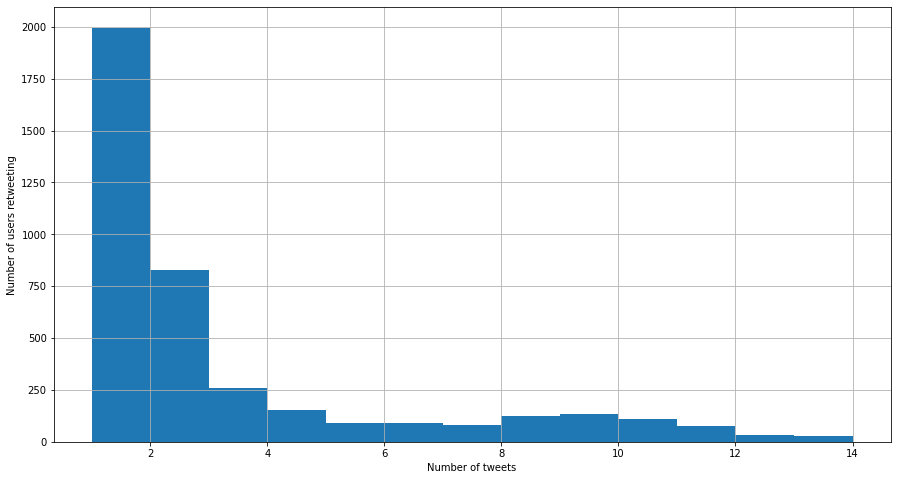

In [66]:
ax = pd.Series([x[1] for x in user_counts.most_common()]).hist(figsize=(15,8), bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14])
ax.set_ylabel("Number of users retweeting")
ax.set_xlabel("Number of tweets");

In [94]:
users = {}

for t, retweets in complete_dataframe[complete_dataframe.type=='retweet'].groupby('time_trump_retweeted'):
    retweets = retweets.sort_values(by='created_at').reindex()
        
    for idx, tweet in retweets.iterrows():
        if tweet.user_id in users:
            users[tweet.user_id]['tweet'+str(t)] = tweet.created_at
        else:                
            users[tweet.user_id] = {'tweet'+str(t):tweet.created_at, 'user_id':tweet.user_id}
for_jim = pd.DataFrame(users.values())

In [95]:
for_jim['username'] = for_jim.user_id.apply(lambda u: set(complete_dataframe[complete_dataframe.user_id==u].username))
for_jim['source'] = for_jim.user_id.apply(lambda u: set(complete_dataframe[complete_dataframe.user_id==u].source))
for_jim['join_date'] = for_jim.user_id.apply(lambda u: complete_dataframe[complete_dataframe.user_id==u].user_join_date.min())
for_jim.set_index('user_id')

,tweetApr 25 07:12:10 (EST),tweetApr 25 08:05:51 (EST),tweetApr 25 08:08:14 (EST),tweetApr 25 08:04:07 (EST),tweetApr 25 08:01:56 (EST),tweetApr 25 08:05:26 (EST),tweetMay 1 18:28:32 (EST),tweetApr 25 07:12:52 (EST),tweetApr 25 08:02:37 (EST),tweetApr 25 08:02:51 (EST),tweetApr 25 08:05:16 (EST),tweetApr 25 08:07:15 (EST),tweetMay 24 21:29:05 (EST),tweetMay 24 21:29:01 (EST),username,source,join_date
user_id,,,,,,,,,,,,,,,,,
156662055,2020-04-24T21:09:13+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{pmramani},"{<a href=""http://twitter.com/download/iphone"" ...",Thu Jun 17 15:03:07 +0000 2010
849463051464192000,2020-04-24T21:09:15+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{constanza_caa},"{<a href=""http://twitter.com/download/iphone"" ...",Wed Apr 05 03:25:48 +0000 2017
568963331,2020-04-24T21:09:16+00:00,2020-04-22T22:22:54+00:00,2020-04-21T16:49:10+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{juanparza},"{<a href=""http://twitter.com/#!/download/ipad""...",Wed May 02 09:45:31 +0000 2012
2386878706,2020-04-24T21:09:17+00:00,NaN,NaN,2020-04-23T20:37:50+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{e_daisyjackson7},"{<a href=""http://twitter.com/download/iphone"" ...",Thu Mar 06 00:21:21 +0000 2014
1190419997140631552,2020-04-24T21:09:18+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{EmilyLeonella},"{<a href=""http://twitter.com/download/iphone"" ...",Sat Nov 02 00:07:08 +0000 2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798034162179538944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-29T19:34:54+00:00,NaN,{RyanIrelanJane},"{<a href=""https://mobile.twitter.com"" rel=""nof...",Mon Nov 14 05:25:45 +0000 2016
3146781148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-31T14:47:29+00:00,NaN,{Alikap88},"{<a href=""http://twitter.com/download/iphone"" ...",Wed Apr 08 05:53:02 +0000 2015
1267256625896792064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-06-01T00:51:33+00:00,NaN,{fightthespread},"{<a href=""http://twitter.com/download/iphone"" ...",Mon Jun 01 00:48:39 +0000 2020


In [98]:
for_jim.head().set_index('user_id').to_csv('retweeted_times_with_dates.csv')